# Filling Missing Data

This report serves as the base for filling missing data in our datasets. It outlines the methods used to handle missing values, the rationale behind choosing these methods, and the impact on the overall data quality.

**Jakob Balkovec**  
**Date: Nov 5, 2025**

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SAT_FILE = Path("/Users/jbalkovec/Desktop/MDR/Temporal/Pipeline/experiments/missing_values/satellite/satellite_data_darrington_2022_2024.csv")
df = pd.read_csv(SAT_FILE, parse_dates=["date"])

In [3]:
df.head()

,date,LST,NDVI,Rain_sat
0,2022-01-01,NaN,0.424939,0.072021
1,2022-01-02,NaN,NaN,0.188750
2,2022-01-03,NaN,NaN,0.379583
3,2022-01-04,NaN,NaN,0.131042
4,2022-01-05,NaN,NaN,0.047917


Text(0.5, 1.0, 'Missing Data Patterns (Darrington 2023)')

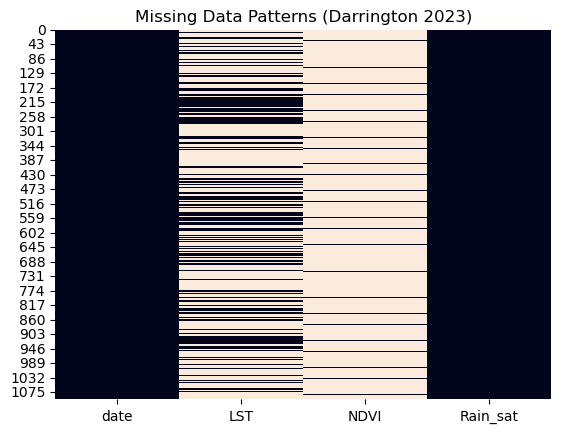

In [4]:
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Data Patterns (Darrington 2023)")

<Axes: xlabel='date'>

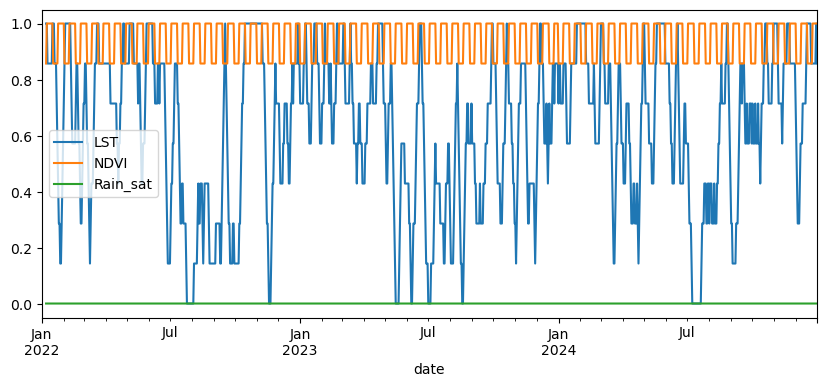

In [5]:
df.set_index("date")[["LST", "NDVI", "Rain_sat"]].isna().rolling(7).mean().plot(figsize=(10,4))

## Max Gap

In [6]:
df["date"] = pd.to_datetime(df["date"])

def gap_stats(series):
    """Return largest gap and frequency of each gap (in days) between valid observations."""
    valid_dates = df.loc[series.notna(), "date"].sort_values().reset_index(drop=True)
    if len(valid_dates) < 2:
        return {"max_gap": np.nan, "gap_counts": {}}

    gaps = valid_dates.diff().dt.days.dropna().astype(int)

    gap_counts = gaps.value_counts().sort_index().to_dict()
    max_gap = int(gaps.max())

    return {"max_gap": max_gap, "gap_counts": gap_counts}

stats = {col: gap_stats(df[col]) for col in ["LST", "NDVI", "Rain_sat"]}

print("=== Gap Statistics (days) ===")
for col, info in stats.items():
    print(f"\n{col}:")
    print(f"  Largest gap: {info['max_gap']} days")
    if not info["gap_counts"]:
        print("  No valid data or only one observation.")
        continue
    print("  Gap length frequencies:")
    for gap, count in info["gap_counts"].items():
        print(f"    {gap:>3} days = {count} occurrences")

=== Gap Statistics (days) ===

LST:
  Largest gap: 32 days
  Gap length frequencies:
      1 days = 246 occurrences
      2 days = 51 occurrences
      3 days = 32 occurrences
      4 days = 14 occurrences
      5 days = 16 occurrences
      6 days = 10 occurrences
      7 days = 13 occurrences
      8 days = 7 occurrences
      9 days = 8 occurrences
     10 days = 4 occurrences
     11 days = 3 occurrences
     13 days = 3 occurrences
     14 days = 1 occurrences
     15 days = 1 occurrences
     16 days = 1 occurrences
     19 days = 1 occurrences
     20 days = 1 occurrences
     32 days = 1 occurrences

NDVI:
  Largest gap: 16 days
  Gap length frequencies:
     13 days = 2 occurrences
     16 days = 66 occurrences

Rain_sat:
  Largest gap: 1 days
  Gap length frequencies:
      1 days = 1095 occurrences


In [8]:
from impute_models import bridge_test, run_linear, run_xgboost, run_rolling

results = []

models = {
    "linear": run_linear,
    "rolling": run_rolling,
    "xgboost": run_xgboost
}

# notes:
#   not testing "rain_sat" because it has no missing values to impute
#   excluding gap >= 32 due to infeasibility (no valid segments available)
for col in ["LST", "NDVI"]:
    for gap in [3, 7, 16]:
        for model_name, model_fn in models.items():
            try:
                # pass model_name directly
                res = bridge_test(
                    df,
                    col,
                    model_fn=model_fn,
                    model_type=model_name,
                    gap=gap,
                    verbose=False
                )
                results.append(res)
            except Exception as e:
                print(f"[WARN] Skipped {col} | {model_name} | gap={gap}: {e}")

results_df = pd.DataFrame(results)
print(results_df.head())

  feature start_date   end_date  gap_days    true_val    pred_val     error  \
0     LST 2022-01-09 2022-01-19        10  275.393111  277.979355  2.586244   
1     LST 2022-01-09 2022-01-19        10  275.393111  275.146802 -0.246309   
2     LST 2022-01-09 2022-01-19        10  275.393111  275.392151 -0.000960   
3     LST 2022-01-09 2022-01-19        10  275.393111  277.979355  2.586244   
4     LST 2022-01-09 2022-01-19        10  275.393111  275.146802 -0.246309   

   abs_error      RMSE       MAE  \
0   2.586244  2.586244  2.586244   
1   0.246309  0.246309  0.246309   
2   0.000960  0.000960  0.000960   
3   2.586244  2.586244  2.586244   
4   0.246309  0.246309  0.246309   

                                      interp_segment    model  
0           date         LST  LST_interp
0  2022-...   linear  
1           date         LST  LST_interp
0  2022-...  rolling  
2           date         LST  LST_interp
0  2022-...  xgboost  
3           date         LST  LST_interp
0  2022-...

In [10]:
df = results_df.copy()
df["RMSE"] = df["RMSE"].astype(float)
df["MAE"] = df["MAE"].astype(float)
df["abs_error"] = df["abs_error"].astype(float)

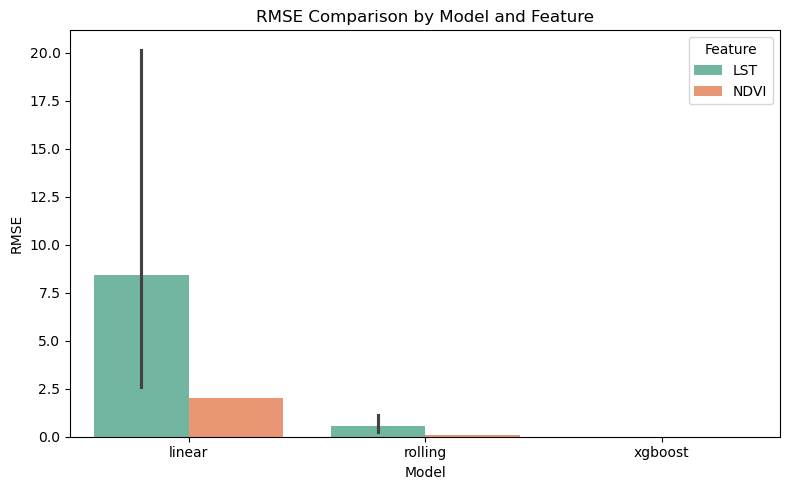

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="model", y="RMSE", hue="feature", palette="Set2")
plt.title("RMSE Comparison by Model and Feature")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.legend(title="Feature")
plt.tight_layout()
plt.show()

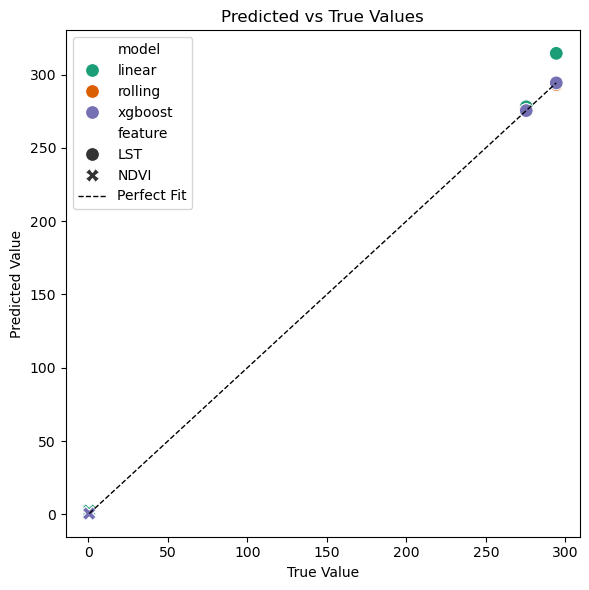

In [12]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df,
    x="true_val",
    y="pred_val",
    hue="model",
    style="feature",
    s=100,
    palette="Dark2"
)
plt.plot(
    [df["true_val"].min(), df["true_val"].max()],
    [df["true_val"].min(), df["true_val"].max()],
    "k--", lw=1, label="Perfect Fit"
)
plt.title("Predicted vs True Values")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.legend()
plt.tight_layout()
plt.show()

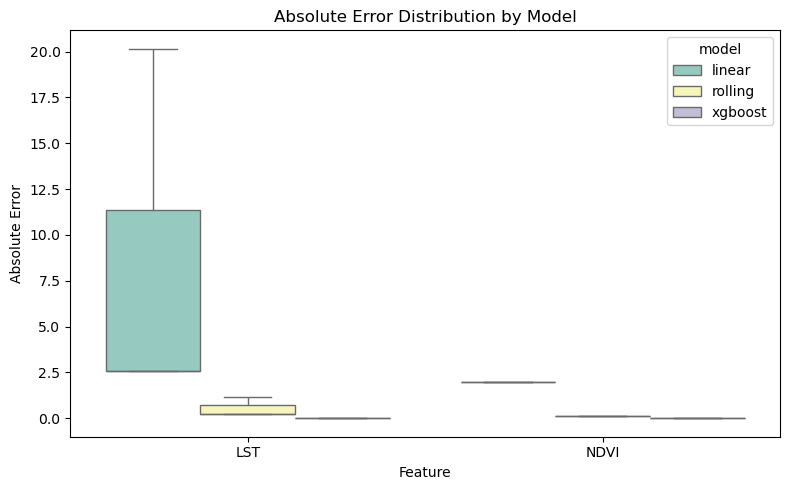

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="feature", y="abs_error", hue="model", palette="Set3")
plt.title("Absolute Error Distribution by Model")
plt.ylabel("Absolute Error")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

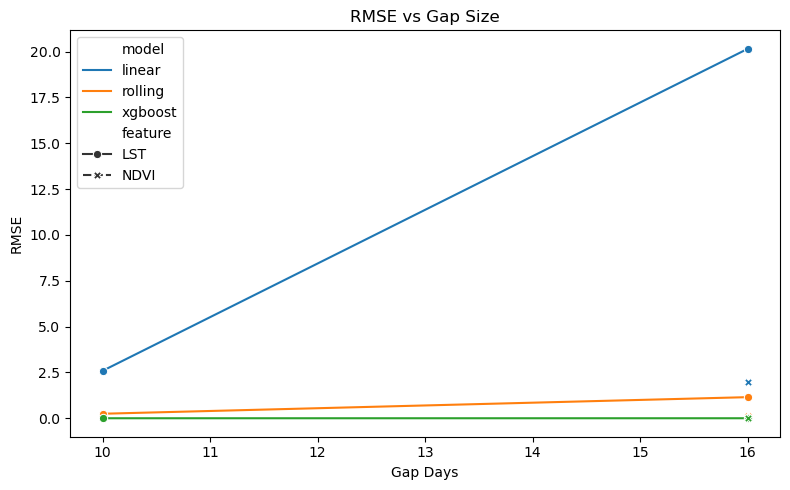

In [ ]:
if "gap_days" in df.columns and df["gap_days"].nunique() > 1:
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df, x="gap_days", y="RMSE", hue="model", style="feature", markers=True)
    plt.title("RMSE vs Gap Size")
    plt.ylabel("RMSE")
    plt.xlabel("Gap Days")
    plt.tight_layout()
    plt.show()